In [1]:
library(ggplot2, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    col

In [2]:
# load(".RData") # load instead of rerunning analyses below

First want to try to run with just those genes we identified as part of ADS operon

In [3]:
# volcano plots showing all significant genes, highlighting those from different strep species
metadata <- read.table("../03-diff_abundance/map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
genecounts <- read.table("syntenous_for_deseq.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")

In [4]:
# only compare PD to PF
metadata <- metadata[metadata$tooth_type != "PE",]
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[order(colnames(genecounts)),]
# colnames(genecounts)
# rownames(metadata)
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PF"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 336 60 
metadata(1): version
assays(1): counts
rownames(336): SEQF2031_01762 SEQF2450_00960 ... SEQF1610_00215
  SEQF1947_02232
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(12): sample_id tooth_type ... Prop_Smutans Smutans_cat

In [5]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm 
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function
norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 122 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



   user  system elapsed 
 18.512   0.757  14.130 

In [6]:
res <- results(se_star, alpha=0.05)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.05: ", sum(res$padj < 0.05, na.rm=TRUE))
summary(res)

[1] "number of genes with adjusted p value lower than 0.05:  224"


out of 336 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 59, 18%
LFC < 0 (down)     : 165, 49%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [7]:
resultsNames(se_star)

[1] "Intercept"           "tooth_type_PF_vs_PD"

In [8]:
resLFC <- lfcShrink(se_star, coef="tooth_type_PF_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(resLFC$padj < 0.01, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results_allADS.txt", quote=F, sep="\t")
save.image()

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of genes with adjusted p value lower than 0.01:  187"


out of 336 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 67, 20%
LFC < 0 (down)     : 171, 51%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [9]:
# transform for visualizations
vld <- varianceStabilizingTransformation(se_star)

pdf 
  2

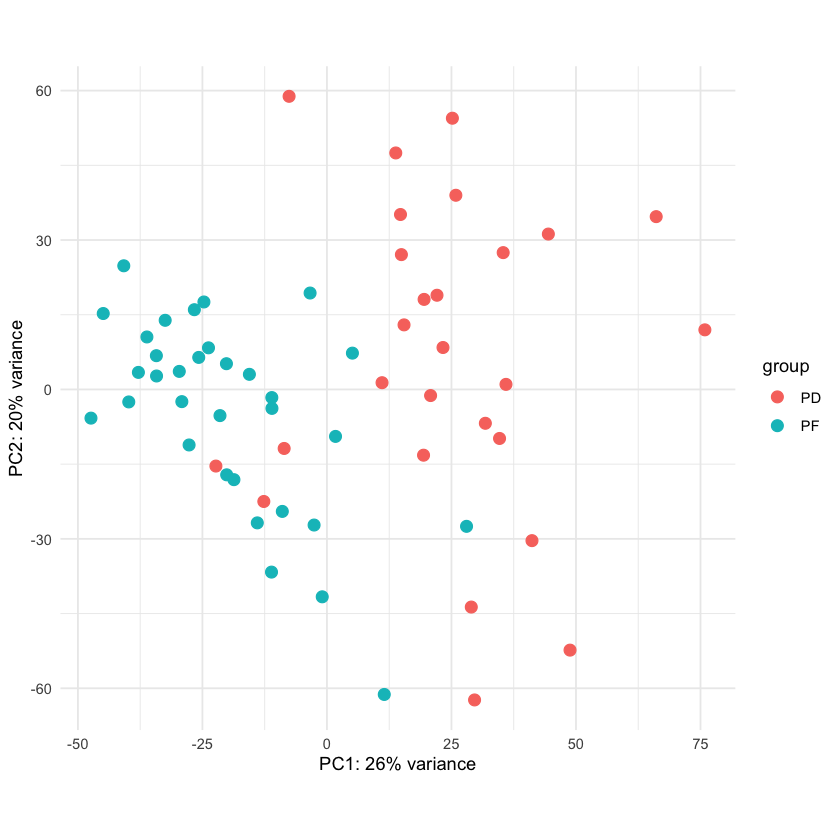

In [10]:
pdf("pca_pdvpf_allADS.pdf")
plotPCA(vld, intgroup=c("tooth_type")) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type")) + theme_minimal()

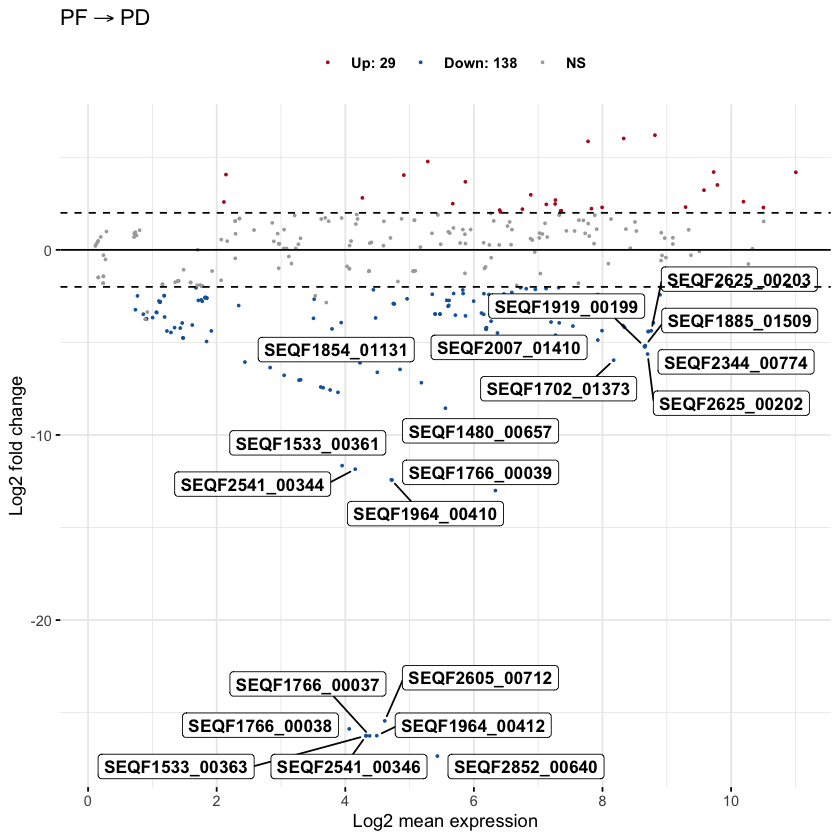

In [11]:
# install.packages("ggpubr")
library(ggpubr)
options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 20,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   ggtheme = ggplot2::theme_minimal())
p

pdf 
  2

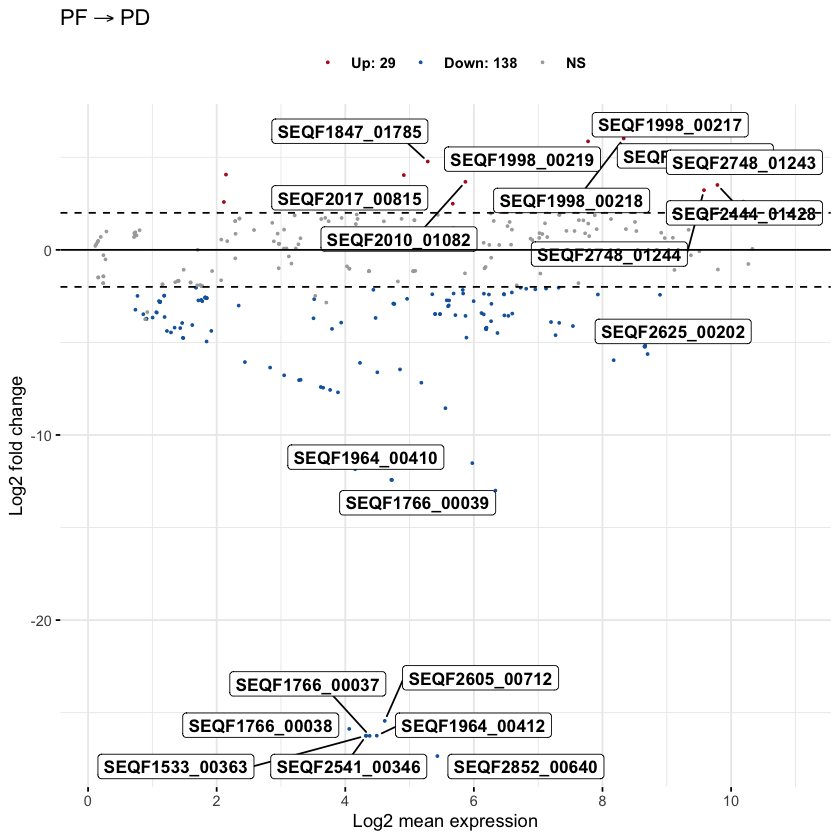

In [12]:
# get labels for top up and top down regulated genes
upreg <- res[res$log2FoldChange > 2,]
downreg <- res[res$log2FoldChange < -2,]
# rank by p value, get top 10
upregname <- row.names(upreg[rank(upreg$padj) <= 10,])
# bottom 10
downregname <- row.names(downreg[rank(downreg$padj) <= 10,])
regnames <- c(upregname, downregname)

options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = regnames,
   ggtheme = ggplot2::theme_minimal())
p
pdf("ads_volcano_plot.pdf")
p
dev.off()

pdf 
  2

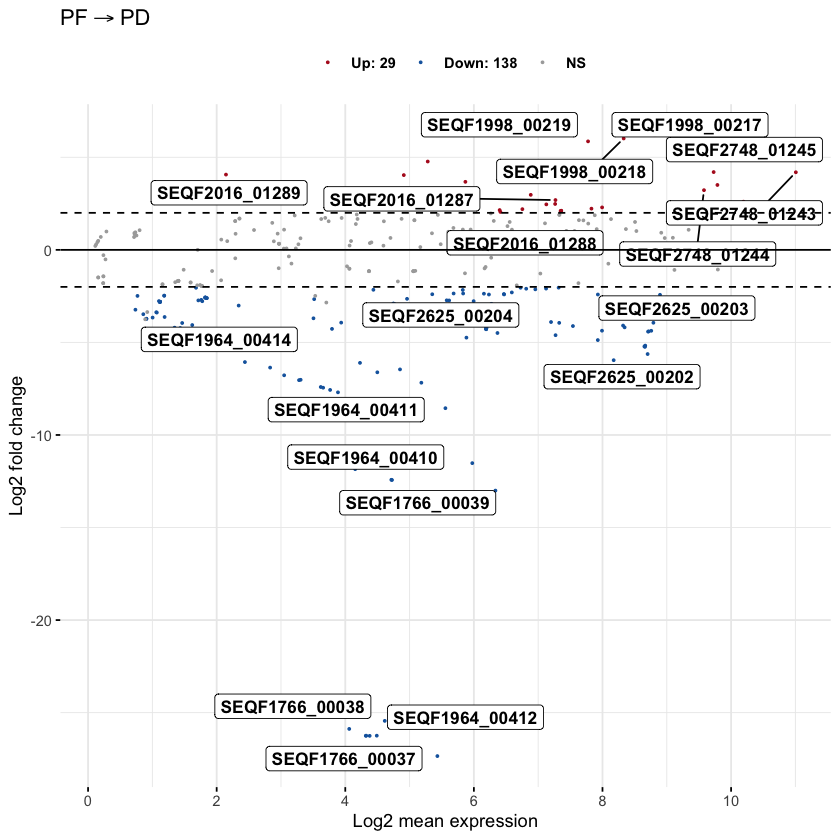

In [28]:
# label specific species based on sig_deseq_results.txt
# top five based on log fold change and mean (of a single gene in the ADS pathway)
options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = c("SEQF2748_01243", "SEQF2748_01244", "SEQF2748_01245", "SEQF2016_01287", "SEQF2016_01288", "SEQF2016_01289", "SEQF1998_00217", "SEQF1998_00218", "SEQF1998_00219", "SEQF1964_00410", "SEQF1964_00411", "SEQF1964_00412", "SEQF1964_00414", "SEQF2625_00202", "SEQF2625_00203", "SEQF2625_00204", "SEQF1766_00037", "SEQF1766_00038", "SEQF1766_00039"),
   ggtheme = ggplot2::theme_minimal())
p
pdf("ads_volcano_plot_5species.pdf")
p
dev.off()

In [14]:
write.table(p$data, "sig_genes_from_volcanoplot.txt", sep = "\t")
p$data

,name,mean,lfc,padj,sig
,<chr>,<dbl>,<dbl>,<dbl>,<fct>
1,SEQF1533_00363,4.318967,-26.250052,6.195516e-75,Down: 160
2,SEQF2541_00346,4.325707,-26.245678,6.195516e-75,Down: 160
3,SEQF1766_00037,4.379325,-26.254056,7.745610e-75,Down: 160
4,SEQF1766_00038,4.061416,-25.879519,1.476387e-74,Down: 160
5,SEQF1964_00412,4.489863,-26.245097,3.357524e-74,Down: 160
6,SEQF2605_00712,4.613976,-25.444866,1.008872e-66,Down: 160
7,SEQF2852_00640,5.432169,-27.347144,9.515158e-50,Down: 160
8,SEQF1766_00039,4.726295,-12.432265,2.324163e-19,Down: 160
9,SEQF1964_00410,4.716023,-12.421135,2.324163e-19,Down: 160


pdf 
  2

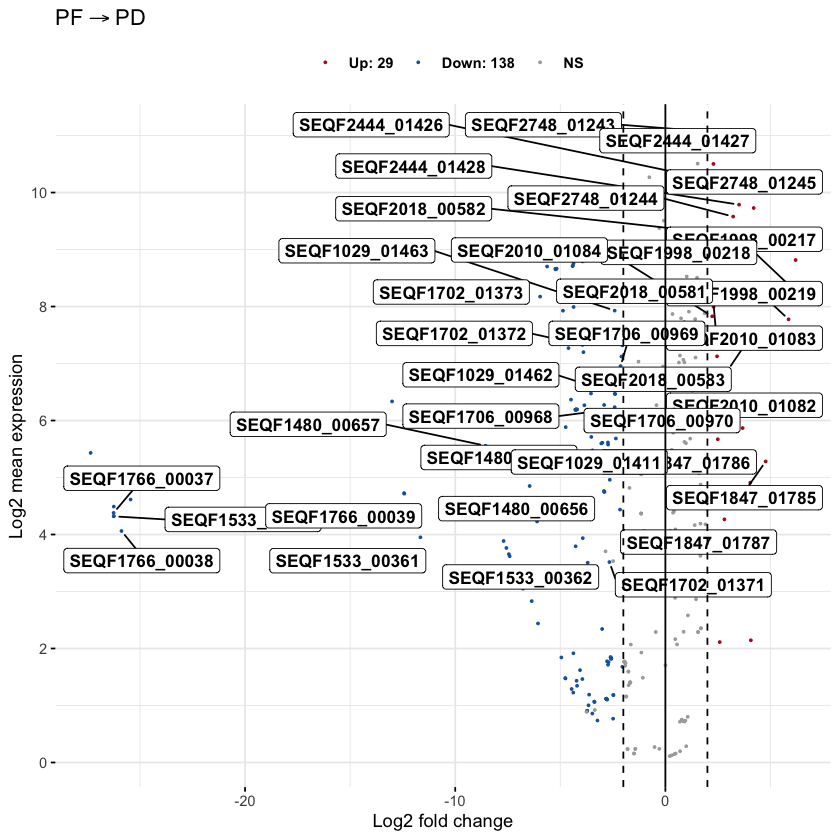

In [29]:
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = c("SEQF1847_01785",
"SEQF1847_01786",
"SEQF1847_01787",
"SEQF1998_00217",
"SEQF1998_00218",
"SEQF1998_00219",
"SEQF2010_01082",
"SEQF2010_01083",
"SEQF2010_01084",
"SEQF2018_00581",
"SEQF2018_00582",
"SEQF2018_00583",
"SEQF2444_01426",
"SEQF2444_01427",
"SEQF2444_01428",
"SEQF2748_01243",
"SEQF2748_01244",
"SEQF2748_01245",
"SEQF1029_01411",
"SEQF1029_01462",
"SEQF1029_01463",
"SEQF1480_00656",
"SEQF1480_00657",
"SEQF1480_00658",
"SEQF1533_00361",
"SEQF1533_00362",
"SEQF1533_00363",
"SEQF1702_01371",
"SEQF1702_01372",
"SEQF1702_01373",
"SEQF1706_00968",
"SEQF1706_00969",
"SEQF1706_00970",
"SEQF1766_00037",
"SEQF1766_00038",
"SEQF1766_00039"),
   ggtheme = ggplot2::theme_minimal(),
   rotate = T)
pdf("ads_volcano_plot_rotate.pdf")
p
dev.off()
p